# A Simple transformer question and answer model needs:
* Tokinizer (Here i am using BERT's way to tokenize beginning and end of sentences)
* Transformer encoder
* QA head (predict start and end position)
* Training and inference logic



# Use self-built attention head

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

In [ ]:
config = {
        "vocab_size": 45,
        "hidden_size": 64,
        "max_position_embeddings": 64,
        "num_attention_heads": 4,
        'intermediate_size':10,
        'hidden_dropout_prob':0.01,
        "num_hidden_layers": 12,
        'mask':None
    }

In [ ]:
## Tokinizer

class SimpleTokinizer:
  def __init__(self):
    self.vocab = {"[PAD]":0, "[CLS]":1, "[SEP]":2,"[UNK]":3}
    self.reverse_vocab = {0:"[PAD]", 1:"[CLS]", 2:"[SEP]",3:"[UNK]"}
    self.idx = 4

  def build_vocab(self,texts):
    for text in texts:
      for word in text.lower().split():
        if word not in self.vocab:
          self.vocab[word] = self.idx
          self.reverse_vocab[self.idx] = word
          self.idx+=1
  def encode(self, question, contaxt, max_len = 64):
    ## for each QA, input takes format of [CLS] question tokens [SEP] context tokens [SEP]
    tokens = ["[CLS]"]+question.lower().split()+["[SEP]"]+contaxt.lower().split()+["[SEP]"]
    token_ids = [self.vocab.get(token, self.vocab["[UNK]"]) for token in tokens]
    token_type_ids = [1]*(len(question.split())+2)+[2]*(len(context.split())+1)
    attention_mask = [1] * len(token_ids)
    padding = [0]*(max_len - len(token_ids))
    # print(token_type_ids)
    return {
        'input_ids':torch.tensor(token_ids + padding[:max_len - len(token_ids)]),
        'attention_mask':torch.tensor(attention_mask+padding[:max_len - len(token_ids)]),
        'token':tokens+['[PAD]']*len(padding),
        'token_type_ids':torch.tensor(token_type_ids+padding[:max_len - len(token_ids)]),

    }

In [ ]:
## Sample
question = "What is KNN?"
context = '''KNN, or k-Nearest Neighbors, is a supervised machine learning algorithm used for both classification and regression tasks. It classifies new data points by finding the "k" most similar data points (neighbors) in the training data and assigning the new data point to the majority class among those neighbors.'''


In [ ]:
## Tokenizer
tokenizer = SimpleTokinizer()
tokenizer.build_vocab([question, context])
# input_ids, attention_mask = tokenizer.encode(question, context)
inputs = tokenizer.encode(question, context)

In [ ]:
# inputs

In [ ]:
# input_ids = input_ids.unsqueeze(0)
# attention_mask = attention_mask.unsqueeze(0)

In [ ]:
# config['mask'] = attention_mask

In [ ]:
# input_ids.shape, attention_mask.shape

In [ ]:
## Atttention head

def scaled_dot_product_attention(q,k,v, mask = None):
  # print(q.shape,k.shape,v.shape)
  dim_k = k.size(-1) ## embedding size
  # print(dim_k)
  # print(k.transpose(1,2).shape)
  scores = torch.bmm(q,k.transpose(1,2)) / math.sqrt(dim_k)
  if mask is not None:
    scores = scores.masked_fill(mask==0, -float('inf'))
  weights = F.softmax(scores, dim=1)
  attention_outputs = torch.bmm(weights, v)
  return attention_outputs


class AttentionHead(nn.Module):
  def __init__(self, embed_dim, head_dim, mask=None):
    super().__init__()
    self.q = nn.Linear(embed_dim, head_dim)
    self.k = nn.Linear(embed_dim, head_dim)
    self.v = nn.Linear(embed_dim, head_dim)
    self.mask = mask

  def forward(self,hidden_state):
    attention_outputs = scaled_dot_product_attention(self.q(hidden_state),self.k(hidden_state),self.v(hidden_state), mask = self.mask)

    return attention_outputs


class MultiHeadAttention(nn.Module):
  def __init__(self,config):
    super().__init__()
    embed_dim = config['hidden_size']
    num_heads = config['num_attention_heads']
    head_dim = embed_dim // num_heads
    mask = config['mask']
    self.heads = nn.ModuleList(
        [AttentionHead(embed_dim, head_dim, mask) for _ in range(num_heads)]
    )
    self.output_linear = nn.Linear(embed_dim, embed_dim)

  def forward(self,hidden_state):
    # print(hidden_state.shape)
    # for h in self.heads:
    #   print(h(hidden_state)[0][0].shape)
    # print(self.heads)
    x = torch.cat([h(hidden_state) for h in self.heads], dim = -1)
    x = self.output_linear(x)
    return x



In [ ]:
AttentionHead(config['hidden_size'], config['num_attention_heads'], config['mask'])

In [ ]:
multihead_attn = MultiHeadAttention(config)
token_emb = nn.Embedding(config['vocab_size'], config['hidden_size'])
input_embeds = token_emb(inputs['input_ids'])
input_embeds = input_embeds.unsqueeze(0)
attn_output = multihead_attn(input_embeds)

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.linear1 = nn.Linear(config['hidden_size'], config['intermediate_size'])
    self.linear2 = nn.Linear(config['intermediate_size'], config['hidden_size'])
    self.gelu = nn.GELU()
    self.dropout = nn.Dropout(config['hidden_dropout_prob'])

  def forward(self,x):
    x = self.linear1(x)
    x = self.gelu(x)
    x = self.linear2(x)
    x = self.dropout(x)
    return x


In [ ]:
feed_forward = FeedForward(config)

In [ ]:
ff_outputs = feed_forward(attn_output)

In [ ]:
ff_outputs.shape

In [ ]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(config['hidden_size'])
    self.layer_norm2 = nn.LayerNorm(config['hidden_size'])
    self.attention = MultiHeadAttention(config)
    self.feedforward = FeedForward(config)
  def forward(self, x):
    hidden_state = self.layer_norm1(x)
    atten_output =  self.attention(hidden_state)
    x+=atten_output
    x += self.feedforward(self.layer_norm2(x))
    return x


In [ ]:
encoder_layer = TransformerEncoderLayer(config)
print(input_embeds.shape)
encoder_layer(input_embeds).shape

In [ ]:
class Embeddings(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.token_embeddings = nn.Embedding(config['vocab_size'], config['hidden_size'])
    self.position_embeddings = nn.Embedding(config['max_position_embeddings'], config['hidden_size'])
    self.layer_norm = nn.LayerNorm(config['hidden_size'], eps = 1e-12)
    self.dropout = nn.Dropout()

  def forward(self, input_ids):
    seq_length = input_ids.unsqueeze(0).size(1)
    position_ids = torch.arange(seq_length, dtype = torch.long).unsqueeze(0)
    # print(input_ids)
    token_embeddings = self.token_embeddings(input_ids)
    position_embeddings = self.position_embeddings(position_ids)
    embeddings = token_embeddings+position_embeddings
    embeddings = self.layer_norm(embeddings)
    embeddings = self.dropout(embeddings)
    return embeddings



In [ ]:
embedding_layer = Embeddings(config)
embedding_layer(inputs['input_ids'])#.size()

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.embeddings = Embeddings(config)
    self.layers = nn.ModuleList(
        [TransformerEncoderLayer(config) for _ in range(config['num_hidden_layers'])]
    )
  def forward(self,x):
    x = self.embeddings(x)
    for layer in self.layers:
      # print(layer)
      x = layer(x)
    return x

In [ ]:
encoder = TransformerEncoder(config)
encoder(inputs['input_ids']).size()

In [ ]:
## Add a QA head
class QA_Transformer(nn.Module):
  def __init__(self, vocab_size, d_model = 64, max_len = 64, heads = 4):
    super().__init__()
    self.config = {
        "vocab_size": vocab_size,
        "hidden_size": d_model,
        "max_position_embeddings": max_len,
        "num_attention_heads": heads,
        'intermediate_size':10,
        'hidden_dropout_prob':0.01,
        "num_hidden_layers": 12,
        'mask':None
    }
    # self.embedding = nn.Embedding(self.config['vocab_size'], self.config['hidden_size'])
    self.encoder = TransformerEncoder(self.config)
    # self.position_embeddings = nn.Parameter(torch.randn(1, self.config['max_position_embeddings'], self.config['hidden_size']))
    # self.position_embeddings = nn.Parameter(torch.randint(1, self.config['max_position_embeddings'], self.config['hidden_size']))
    self.qa_outputs = nn.Linear(self.config['hidden_size'], 2)

  def forward(self, input_ids):#, attention_mask):
    input_ids = input_ids.unsqueeze(0)
    # attention_mask = attention_mask.unsqueeze(0)
    # x = self.embedding(input_ids)+self.position_embeddings[:,:input_ids.size(1)]#.long()
    x = self.encoder(input_ids)#, attention_mask)
    logits = self.qa_outputs(x)
    start_logits, end_logits = logits.split(1,dim=-1)
    return start_logits.squeeze(-1), end_logits.squeeze(-1)




In [ ]:
## Sample
question = "What is KNN?"
context = '''KNN, or k-Nearest Neighbors, is a supervised machine learning algorithm used for both classification and regression tasks. It classifies new data points by finding the "k" most similar data points (neighbors) in the training data and assigning the new data point to the majority class among those neighbors.'''


In [ ]:
## Tokenizer
tokenizer = SimpleTokinizer()
tokenizer.build_vocab([question, context])
# input_ids, attention_mask = tokenizer.encode(question, context)
# input_ids = input_ids.unsqueeze(0)
# attention_mask = attention_mask.unsqueeze(0)
input = tokenizer.encode(question, context)

In [ ]:
# input['input_ids']

In [ ]:
input['attention_mask'].shape, input['input_ids'].shape, len(tokenizer.vocab)

In [ ]:
input['input_ids'].shape

In [ ]:
## Model
model = QA_Transformer(vocab_size =len(tokenizer.vocab), d_model = 64, max_len = 64, heads = 4)
# start_logits, end_logits = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
start_logits, end_logits = model(input['input_ids'])#, input['attention_mask'])

In [ ]:
# start_logits, end_logits

In [ ]:
# Get answer span
start_idx = torch.argmax(start_logits, dim=1).item()
end_idx = torch.argmax(end_logits, dim=1).item()
print(start_idx, end_idx)
tokens = inputs['input_ids'].tolist()
# print(tokens)
answer = [tokenizer.reverse_vocab.get(t, '[UNK]') for t in tokens[start_idx:end_idx+1]]
print("Predicted answer:", " ".join(answer))

## Model has not been trained yet and no seed is set so output is very unstable

### Output from the above:
46 58
Predicted answer: to the majority class among those neighbors. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]

### But sometimes it could be empty.

# Existing attention head from pytorch

In [2]:
class SimpleTokenizer:
    def __init__(self):
        self.vocab = {"[PAD]": 0, "[CLS]": 1, "[SEP]": 2, "[UNK]": 3}
        self.reverse_vocab = {0: "[PAD]", 1: "[CLS]", 2: "[SEP]", 3: "[UNK]"}
        self.idx = 4

    def build_vocab(self, texts):
        for text in texts:
            for word in text.lower().split():
                if word not in self.vocab:
                    self.vocab[word] = self.idx
                    self.reverse_vocab[self.idx] = word
                    self.idx += 1

    def encode(self, question, context, max_len=64):
        tokens = ["[CLS]"] + question.lower().split() + ["[SEP]"] + context.lower().split() + ["[SEP]"]
        token_ids = [self.vocab.get(token, self.vocab["[UNK]"]) for token in tokens]
        attention_mask = [1] * len(token_ids)
        padding = [0] * (max_len - len(token_ids))
        return (
            torch.tensor(token_ids + padding[:max_len - len(token_ids)]),
            torch.tensor(attention_mask + padding[:max_len - len(token_ids)])
        )


In [3]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim)
        )
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x, mask):
        # print(x)
        attn_output, _ = self.attn(x, x, x, key_padding_mask=~mask.bool())
        # print(attn_output)
        x = self.norm1(x + attn_output)
        ff_output = self.ff(x)
        x = self.norm2(x + ff_output)
        return x


In [4]:
class QA_Transformer(nn.Module):
    def __init__(self, vocab_size, d_model=64, max_len=64, heads=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, d_model))
        self.encoder = TransformerBlock(d_model, heads)
        self.qa_outputs = nn.Linear(d_model, 2)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids) + self.pos_embedding[:, :input_ids.size(1)]
        # print(x.shape)
        x = self.encoder(x, attention_mask)
        # print(x.shape)
        logits = self.qa_outputs(x)  # [batch, seq_len, 2]
        start_logits, end_logits = logits.split(1, dim=-1)
        return start_logits.squeeze(-1), end_logits.squeeze(-1), x


In [6]:
# Sample data
question = "What is KNN?"
context = '''KNN, or k-Nearest Neighbors, is a supervised machine learning algorithm used for both classification and regression tasks. It classifies new data points by finding the "k" most similar data points (neighbors) in the training data and assigning the new data point to the majority class among those neighbors.'''


# Tokenizer
tokenizer = SimpleTokenizer()
tokenizer.build_vocab([question, context])
input_ids, attention_mask = tokenizer.encode(question, context)

# Model
model = QA_Transformer(vocab_size=len(tokenizer.vocab))
start_logits, end_logits,x = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))

# Get answer span
start_idx = torch.argmax(start_logits, dim=1).item()
end_idx = torch.argmax(end_logits, dim=1).item()
tokens = input_ids.tolist()
answer = [tokenizer.reverse_vocab.get(t, '[UNK]') for t in tokens[start_idx:end_idx+1]]
print("Predicted answer:", " ".join(answer))


Predicted answer: finding the "k" most similar data points (neighbors) in the training data and assigning the new data point to


In [8]:
# x

In [ ]:
# tokens[start_idx:end_idx+1]

## Model has not been trained yet and no seed is set so output is very unstable

### output from above:
Predicted answer: is a supervised machine learning algorithm used for both classification and regression tasks. it classifies new data points

### But another run will be different
### Model needs to be trained and set seeds

# Train model with SQuAD data

In [9]:
torch.manual_seed(42)

In [10]:
!pip install datasets

In [11]:
from datasets import load_dataset

## Load SQuAD data
squad = load_dataset('squad')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
# squad

In [13]:
train_data = squad['train']
val_data =squad['validation']

In [ ]:
# train_data

In [ ]:
# val_data

In [ ]:
# train_data[200]

In [ ]:
# val_data[100]['question']

In [14]:
def char_to_token_span(context, answer_start, answer_text, tokenizer):
  words = context.lower().split()
  char_idx = 0
  token_start = token_end = -1
  for i, word in enumerate(words):
    if context.lower().find(answer_text.lower(), char_idx) != -1:
      char_idx = context.lower().find(answer_text.lower(),char_idx)
      token_start = len(context[:char_idx].split())
      token_end = token_start+len(answer_text.split()) - 1
      break
  return token_start, token_end

In [15]:
# Build vocab from all texts in train + validation
tokenizer = SimpleTokenizer()
all_texts = []
for item in train_data:
    all_texts.extend([item["question"], item["context"]])
tokenizer.build_vocab(all_texts)

for item in val_data:
    all_texts.extend([item["question"], item["context"]])
tokenizer.build_vocab(all_texts)

In [16]:
class QADataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_len=64, doc_stride = 32):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.samples = []
        self.doc_stride = doc_stride

        for item in data:
            q = item["question"]
            c = item["context"]
            a = item["answers"]["text"][0]
            a_start = item["answers"]["answer_start"][0]
            self.tokenizer.build_vocab([q, c])
            input_ids, attn_mask = tokenizer.encode(q, c, max_len)
            start, end = char_to_token_span(c, a_start, a, tokenizer)

            # Adjust for [CLS] and question tokens
            offset = 1 + len(q.split()) + 1
            start += offset
            end += offset
            # print(end, max_len)
            if end < max_len:
              # print('end<max_len')
              self.samples.append((input_ids, attn_mask, start, end))

            else:

              q_tokens = q.split()
              c_tokens = c.split()

              ## Sliding window over the context to deal with long context
              doc_start = 0
              # print(q,c,a)
              while doc_start < len(c_tokens):

                doc_end = min(doc_start+(max_len - len(q_tokens) - 3), len(c_tokens))
                # (max_len - len(q_tokens) - 3) because we need to add question tokens and [cls] [sep] [sep] into the total doc feeding into the model.
                # Format input will be like this: [cls] question tokens [sep] context tokens [sep]
                # print(doc_start, doc_end,len(c_tokens))
                # print(c_tokens[doc_start:doc_end])
                # Check if the answer is inside this chunk
                if start >= doc_start and end <= doc_end:
                  # Adjust answer positions relative to this chunk because now it changes
                  adj_start = start - doc_start
                  adj_end = end - doc_start

                  ## input
                  new_context = ' '.join(c_tokens[doc_start:doc_end])
                  self.tokenizer.build_vocab([q, new_context])
                  input_ids, attn_mask = tokenizer.encode(q, new_context, max_len)
                  offset = 1+len(q_tokens)+1
                  start_pos = adj_start+offset
                  end_pos = adj_end+offset
                  # print(start_pos, end_pos)
                  self.samples.append((input_ids, attn_mask, start_pos, end_pos))

                if doc_end == len(c_tokens):
                  break

                doc_start+= self.doc_stride

        # print(self.samples)











    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        input_ids, mask, start, end = self.samples[idx]
        input_ids = F.pad(input_ids, (0, self.max_len - input_ids.shape[0]), value=0)
        mask = F.pad(mask, (0, self.max_len - mask.shape[0]), value=0)
        return {
            "input_ids": input_ids,
            "attention_mask": mask,
            "start_pos": torch.tensor(start),
            "end_pos": torch.tensor(end)
        }


In [17]:

train_dataset = QADataset(train_data.select(range(2000)), tokenizer)  # Use a small subset


In [18]:
# train_data[2]

In [19]:
len(tokenizer.vocab)

206289

In [20]:
train_dataset.__len__()

2253

In [27]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

In [28]:
# torch.cuda.is_available()

In [21]:
epochs=42
# epochs = 3
batch_size=16
lr=5e-4

In [22]:
model = QA_Transformer(vocab_size=len(tokenizer.vocab))


In [23]:
# Train Model




# initial_weights = model.embedding.weight.clone().detach() # Store initial weights

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




dataset = train_dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device) # Move model to device first
model.train()

loss_hist = []

for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        input_ids = batch["input_ids"]
        mask = batch["attention_mask"]
        start_pos = batch["start_pos"]
        end_pos = batch["end_pos"]

        start_logits, end_logits,_ = model(input_ids, mask)
        loss = loss_fn(start_logits, start_pos) + loss_fn(end_logits, end_pos)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader):.4f}")
    loss_hist.append(total_loss / len(dataloader))


Epoch 1: Loss = 8.2756
Epoch 2: Loss = 7.9360
Epoch 3: Loss = 7.6816
Epoch 4: Loss = 7.3043
Epoch 5: Loss = 6.7247
Epoch 6: Loss = 6.0024
Epoch 7: Loss = 5.3292
Epoch 8: Loss = 4.6422
Epoch 9: Loss = 4.0289
Epoch 10: Loss = 3.4528
Epoch 11: Loss = 2.9375
Epoch 12: Loss = 2.4892
Epoch 13: Loss = 2.1058
Epoch 14: Loss = 1.7709
Epoch 15: Loss = 1.4512
Epoch 16: Loss = 1.2225
Epoch 17: Loss = 1.0146
Epoch 18: Loss = 0.8470
Epoch 19: Loss = 0.7396
Epoch 20: Loss = 0.5747
Epoch 21: Loss = 0.5376
Epoch 22: Loss = 0.4471
Epoch 23: Loss = 0.4052
Epoch 24: Loss = 0.3255
Epoch 25: Loss = 0.3003
Epoch 26: Loss = 0.2772
Epoch 27: Loss = 0.2566
Epoch 28: Loss = 0.2317
Epoch 29: Loss = 0.2053
Epoch 30: Loss = 0.1971
Epoch 31: Loss = 0.1789
Epoch 32: Loss = 0.1431
Epoch 33: Loss = 0.1513
Epoch 34: Loss = 0.1649
Epoch 35: Loss = 0.1814
Epoch 36: Loss = 0.1540
Epoch 37: Loss = 0.1603
Epoch 38: Loss = 0.1415
Epoch 39: Loss = 0.1650
Epoch 40: Loss = 0.1660
Epoch 41: Loss = 0.1213
Epoch 42: Loss = 0.1297


In [ ]:
# updated_weights = model.embedding.weight.clone().detach()

In [ ]:
# initial_weights

In [ ]:
# updated_weights

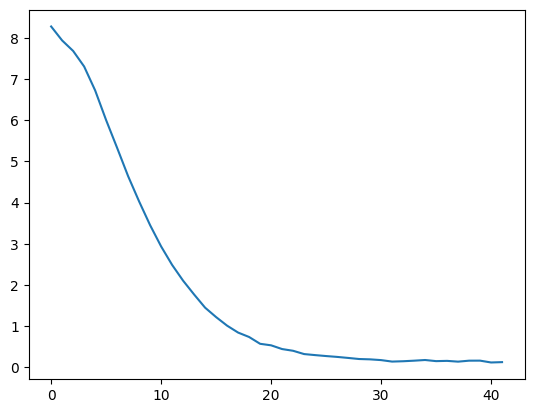

In [40]:
import matplotlib.pyplot as plt
plt.plot(loss_hist)

In [ ]:
# updated_weights = model.embedding.weight.clone().detach()

In [ ]:
# initial_weights

In [ ]:
# updated_weights

In [24]:
def predict_answer(model, tokenizer, input_ids, attention_mask):
  model.eval()
  with torch.no_grad():
    start_logits, end_logits,_ = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
    start = torch.argmax(start_logits, dim=1).item()
    end = torch.argmax(end_logits, dim=1).item()

    max_len = input_ids.size(0)
    if start>end:
      return ""
    tokens = input_ids[start:end+1].tolist()
    words = [tokenizer.reverse_vocab.get(t,'[UNK]') for t in tokens]
    return " ".join(words)


In [25]:
## Since we train with sliding window data, we should add sliding window inference
def sliding_window_inference(question, context, tokenizer, model, max_len = 64, stride = 32):
  input_ids, attention_mask = tokenizer.encode(question, context, max_len)
  q_tokens = question.split()
  c_tokens = context.split()
  q_len = len(q_tokens)
  c_len = len(c_tokens)
  max_context_len = max_len - q_len - 3
  result = []
  doc_start = 0
  while doc_start < c_len:
    doc_end = min(doc_start+max_context_len, c_len)
    new_context = ' '.join(c_tokens[doc_start:doc_end])
    input_ids, attention_mask = tokenizer.encode(question, new_context, max_len)
    pad_len = max_len - len(input_ids)
    input_ids = F.pad(input_ids, (0, pad_len), value=0)
    attention_mask = F.pad(attention_mask, (0, pad_len), value=0)
    # input_ids = input_ids.unsqueeze(0)
    # attention_mask = attention_mask.unsqueeze(0)
    outputs = predict_answer(model, tokenizer, input_ids, attention_mask)
    result.append(outputs)
    doc_start += stride
  return result



In [26]:
import string
def normalize(text):
  def remove_punc(s):
    return "".join(c for c in s if c not in string.punctuation)

  def remove_articles(s):
    return " ".join([w for w in s.split() if w not in ["a",'an','the']])
  return remove_articles(remove_punc(text.lower())).strip()



In [27]:
def compute_f1(pred, truth):
  pred_tokens = normalize(pred).split()
  truth_tokens = normalize(truth).split()
  common = set(pred_tokens) & set(truth_tokens)
  if len(common) == 0: return 0
  precision = len(common) / len(pred_tokens)
  recall = len(common) / len(truth_tokens)
  return 2*(precision*recall) / (precision+recall)

In [28]:
def compute_em(pred,truth):
  return int(normalize(pred) == normalize(truth))

In [29]:
def evaluate(model, dataset, tokenizer, num_samples=100):
  em_scores = []
  f1_scores = []
  for i in range(num_samples):
    sample = dataset.data[i]
    question = sample['question']
    context = sample['context']
    gt_answer = sample['answers']['text'][0]
    input_ids, attention_mask = tokenizer.encode(question, context, max_len = 64)
    # input_ids = input_ids[:64]
    # attention_mask = attention_mask[:64]
    # pred_answer = predict_answer(model, tokenizer, input_ids, attention_mask)
    pred_answer = sliding_window_inference(question, context, tokenizer, model, max_len = 64, stride = 32)
    pred_answer = ' '.join(pred_answer)

    em_scores.append(compute_em(pred_answer, gt_answer))
    f1_scores.append(compute_f1(pred_answer, gt_answer))

  avg_em = sum(em_scores) / len(em_scores)
  avg_f1 = sum(f1_scores) / len(f1_scores)

  print(f"evaluate on {str(num_samples)} \n")
  print(f'exact match: {avg_em:.2%}')
  print(f'f1 score: {avg_f1:.2%}')
  return avg_em, avg_f1

In [30]:
## Val dataset has tokens that are not included in training dataset, hence causing errors
## Might need to train data with both val and train
## Or lemmentization or or better tokenization methods


train_subset = train_data.select(range(1000))
train_dataset = QADataset(train_subset, tokenizer)
evaluate(model, train_dataset, tokenizer,100)

evaluate on 100 

exact match: 4.00%
f1 score: 21.43%


(0.04, 0.2143417426105512)

In [31]:
train_subset[0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

In [32]:
sliding_window_inference(train_subset[0]['question'], train_subset[0]['context'], tokenizer, model, max_len = 64, stride = 32)

['in',
 'basilica of the sacred heart. immediately behind the basilica',
 'direct line that',
 'direct line that']

In [33]:
input_ids, attention_mask = tokenizer.encode(train_subset[0]['question'], train_subset[0]['context'], max_len = 64)
input_ids = input_ids[:64]
attention_mask = attention_mask[:64]
pred_answer = predict_answer(model, tokenizer, input_ids, attention_mask)
print('eval1:',pred_answer)
pred_answer_2 = sliding_window_inference(train_subset[0]['question'], train_subset[0]['context'], tokenizer, model, max_len = 64, stride = 32)
print('eval2:',pred_answer_2)

eval1: in
eval2: ['in', 'basilica of the sacred heart. immediately behind the basilica', 'direct line that', 'direct line that']


In [34]:
val_subset = val_data.select(range(1000))
val_dataset = QADataset(val_subset, tokenizer)
evaluate(model, val_dataset, tokenizer,100)

evaluate on 100 

exact match: 0.00%
f1 score: 3.69%


(0.0, 0.03686981583287873)

In [35]:
val_data[2]

{'id': '56be4db0acb8001400a502ee',
 'title': 'Super_Bowl_50',
 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.',
 'question': 'Where did Super Bowl 50 take place?',
 'answers': {'text': ['Santa Clara, California',
   "Levi's Stadium",
   "Levi's Stadium in th

In [36]:
val_dataset.data[2]['question'], val_dataset.data[2]['answers']

('Where did Super Bowl 50 take place?',
 {'text': ['Santa Clara, California',
   "Levi's Stadium",
   "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."],
  'answer_start': [403, 355, 355]})

In [37]:
input_ids, attention_mask = tokenizer.encode(val_dataset.data[2]['question'], val_dataset.data[2]['context'], max_len = 64)
input_ids = input_ids[:64]
attention_mask = attention_mask[:64]
pred_answer = predict_answer(model, tokenizer, input_ids, attention_mask)
print('eval1:',pred_answer)
pred_answer_2 = sliding_window_inference(val_dataset.data[2]['question'], val_dataset.data[2]['context'], tokenizer, model, max_len = 64, stride = 32)
print('eval2:',pred_answer_2)

eval1: (afc) champion denver broncos defeated the national football conference (nfc) champion carolina panthers 24–10 to earn their third super bowl title. the game was played
eval2: ['(afc) champion denver broncos defeated the national football conference (nfc) champion carolina panthers 24–10 to earn their third super bowl title. the game was played', 'clara,', '', '(under which the game would have been known as "super bowl l"), so that the logo']


In [38]:
question = "What is KNN?"
context = '''KNN, or k-Nearest Neighbors, is a supervised machine learning algorithm used for both classification and regression tasks. It classifies new data points by finding the "k" most similar data points (neighbors) in the training data and assigning the new data point to the majority class among those neighbors.'''
input_ids, attention_mask = tokenizer.encode(question, context, max_len = 64)
# input_ids = input_ids[:64]
# attention_mask = attention_mask[:64]
pred_answer = predict_answer(model, tokenizer, input_ids, attention_mask)
print('eval1:',pred_answer)
pred_answer_2 = sliding_window_inference(question, context, tokenizer, model, max_len = 64, stride = 32)
print('eval2:',pred_answer_2)

eval1: 
eval2: ['', '']


# VectorStore to store long documents / long contexts

## Use KNN to retrieve documents/ contexts for questions

Source: https://medium.com/@vidiptvashist/building-a-vector-database-from-scratch-in-python-6bd683ba5171
https://sarabesh.medium.com/how-i-built-a-vector-db-with-hnsw-from-scratch-a311b6eac082


In [39]:
class knnsearch():
  def __init__(self,k):
    self.k = k

  def cos_similarity_dist(self, vector1, vector2):
    similarity = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    return similarity

  def get_neighbours(self, vector_data, query_vector):

    '''
    Get the k cloest neighbours of the query vector

    input:
      vector_data: a dictionary with query/unique id linked with its vector embedding
      query_vector: query of interests

    '''

    num_neighbours = self.k
    distances = []
    for k,v in vector_data.items():
      dist = self.cos_similarity_dist(query_vector, v['question_vector'])
      distances.append((k,v['question_vector'],dist))

    distances.sort(key=lambda x: x[2], reverse = True) ## Descending order here because higher cosine similairty means more similar
    neighbours = distances[:num_neighbours]
    return neighbours





In [41]:
class VectorStore:
  def __init__(self):
    self.vector_data = {} ## dictionary to store vector

  def add_vector(self, vector_id, vector, context):
    '''
    add a vector to the store
    vector_id: sentence of the vector
    vector: vector data of the question
    question_context: context of the question

    '''
    question_context = {}
    question_context['question_vector'] = vector
    question_context['question_context'] = context

    self.vector_data[vector_id] = question_context

  def get_vector(self,vector_id):
    return self.vector_data[vector_id]['question_vector']

  def get_context(self,vector_id):
    return self.vector_data[vector_id]['question_context']


  def knnsearch(self, query_vector, num_results = 3):
    knn = knnsearch(num_results)
    neighbours = knn.get_neighbours(self.vector_data, query_vector)
    return neighbours











# Testing

In [ ]:


# vector_store = VectorStore()  # Creating an instance of the VectorStore class

# # example taken from https://medium.com/@vidiptvashist/building-a-vector-database-from-scratch-in-python-6bd683ba5171

# # Define sentences
# sentences = [  # Defining a list of example sentences
#     "I eat mango",
#     "mango is my favorite fruit",
#     "Mango is a clothing brand",
#     "fruits are good for health",
# ]

# # Tokenization and Vocabulary Creation
# vocabulary = set()  # Initializing an empty set to store unique words
# for sentence in sentences:  # Iterating over each sentence in the list
#     tokens = sentence.lower().split()  # Tokenizing the sentence by splitting on whitespace and converting to lowercase
#     vocabulary.update(tokens)  # Updating the set of vocabulary with unique tokens

# # Assign unique indices to vocabulary words
# word_to_index = {word: i for i, word in enumerate(vocabulary)}  # Creating a dictionary mapping words to unique indices

# # Vectorization
# sentence_vectors = {}  # Initializing an empty dictionary to store sentence vectors
# for sentence in sentences:  # Iterating over each sentence in the list
#     tokens = sentence.lower().split()  # Tokenizing the sentence by splitting on whitespace and converting to lowercase
#     vector = np.zeros(len(vocabulary))  # Initializing a numpy array of zeros for the sentence vector
#     for token in tokens:  # Iterating over each token in the sentence
#         vector[word_to_index[token]] += 1  # Incrementing the count of the token in the vector
#     sentence_vectors[sentence] = vector  # Storing the vector for the sentence in the dictionary

# # Store in VectorStore
# for sentence, vector in sentence_vectors.items():  # Iterating over each sentence vector
#     vector_store.add_vector(sentence, vector)  # Adding the sentence vector to the VectorStore

# # Similarity Search
# query_sentence = "Mango is the best fruit"  # Defining a query sentence
# query_vector = np.zeros(len(vocabulary))  # Initializing a numpy array of zeros for the query vector
# query_tokens = query_sentence.lower().split()  # Tokenizing the query sentence and converting to lowercase
# for token in query_tokens:  # Iterating over each token in the query sentence
#     if token in word_to_index:  # Checking if the token is present in the vocabulary
#         query_vector[word_to_index[token]] += 1  # Incrementing the count of the token in the query vector
# similar_sentences = vector_store.knnsearch(query_vector, num_results=2)  # Finding 2 similar sentences

# # Display similar sentences
# print("Query Sentence:", query_sentence)  # Printing the query sentence
# print("Similar Sentences:")  # Printing the header for similar sentences


# ## Use KNN search
# for sentence, _, similarity in similar_sentences:  # Iterating over each similar sentence and its similarity score
#     print(f"{sentence}: Similarity = {similarity:.4f}")  # Printing the similar sentence and its similarity score



Query Sentence: Mango is the best fruit <br>
Similar Sentences: <br>
mango is my favorite fruit: Similarity = 0.7746 <br>
Mango is a clothing brand: Similarity = 0.5164 <br>

Here we see that the order and the number of words contribute to similarity. But clearly the second sentence is not as similar to the query than the first candidate

In [109]:
# query_sentence = "Mango is the best fruit"  # Defining a query sentence
# query_vector = np.zeros(len(vocabulary))  # Initializing a numpy array of zeros for the query vector
# query_tokens = query_sentence.lower().split()  # Tokenizing the query sentence and converting to lowercase
# for token in query_tokens:  # Iterating over each token in the query sentence
#     if token in word_to_index:  # Checking if the token is present in the vocabulary
#         query_vector[word_to_index[token]] += 1  # Incrementing the count of the token in the query vector
# query_vector

In [ ]:
# query_tokens

In [ ]:
# word_to_index

In [ ]:
# vocabulary

In [ ]:
# vector1 = np.array([0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0.])
# vector3 = np.array([1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.])
# vector4 = np.array([0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.])
# vector2 = query_vector
# print(np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2)))
# print(np.dot(vector3, vector2) / (np.linalg.norm(vector3) * np.linalg.norm(vector2)))
# print(np.dot(vector4, vector2) / (np.linalg.norm(vector4) * np.linalg.norm(vector2)))

0.0
0.2581988897471611
0.2581988897471611


In [ ]:
# np.linalg.norm(vector1), np.linalg.norm(vector2),np.linalg.norm(vector3) ,np.linalg.norm(vector4)

(np.float64(2.23606797749979), <br>
 np.float64(1.7320508075688772), <br>
 np.float64(2.23606797749979), <br>
 np.float64(2.23606797749979)) <br>


## Formula for the L2 (Euclidean) Norm of a Vector:<br>
For a vector <br>
\begin{equation}
(x=[x_{1},x_{2},...,x_{n}])
\end{equation},
the L2 norm is calculated as:
\begin{equation}
(\|x\|_{2} =\sqrt{\sum_{i=1}^{n}|x_{i} |^{2}})
\end{equation}
This formula represents the square root of the sum of the squares of the absolute values of the vector's elements. In simpler terms, for real-valued vectors, it's the square root of the sum of the squared elements.


## Since we are one hot encoding the sentences, sentences with the same number of word will ahve the same norm in their vectors

In [112]:
# np.dot(vector1, vector2), np.dot(vector3, vector2), np.dot(vector4, vector2)

## Fill in Vector DB



In [42]:
# train_subset = train_data.select(range(1000))

In [64]:
# train_subset[0]

In [63]:
# len(train_subset)
len(train_data)

87599

In [66]:
context_cnt = {}
for i in range(len(train_data)):
  if train_data[i]['context'] in context_cnt:
    context_cnt[train_data[i]['context']] +=1
  else:
    context_cnt[train_data[i]['context']] =1


In [67]:
top_n_items = sorted(context_cnt.items(), key=lambda item: item[1], reverse=True)[:3]
# top_n_keys = [key for key, value in top_n_items]

In [68]:
top_n_items

[('Victoria married her first cousin, Prince Albert of Saxe-Coburg and Gotha, in 1840. Their nine children married into royal and noble families across the continent, tying them together and earning her the sobriquet "the grandmother of Europe". After Albert\'s death in 1861, Victoria plunged into deep mourning and avoided public appearances. As a result of her seclusion, republicanism temporarily gained strength, but in the latter half of her reign her popularity recovered. Her Golden and Diamond Jubilees were times of public celebration.',
  25),
 ('In 1853, Victoria gave birth to her eighth child, Leopold, with the aid of the new anaesthetic, chloroform. Victoria was so impressed by the relief it gave from the pain of childbirth that she used it again in 1857 at the birth of her ninth and final child, Beatrice, despite opposition from members of the clergy, who considered it against biblical teaching, and members of the medical profession, who thought it dangerous. Victoria may have

[('Victoria married her first cousin, Prince Albert of Saxe-Coburg and Gotha, in 1840. Their nine children married into royal and noble families across the continent, tying them together and earning her the sobriquet "the grandmother of Europe". After Albert\'s death in 1861, Victoria plunged into deep mourning and avoided public appearances. As a result of her seclusion, republicanism temporarily gained strength, but in the latter half of her reign her popularity recovered. Her Golden and Diamond Jubilees were times of public celebration.',
  25),
 ('In 1853, Victoria gave birth to her eighth child, Leopold, with the aid of the new anaesthetic, chloroform. Victoria was so impressed by the relief it gave from the pain of childbirth that she used it again in 1857 at the birth of her ninth and final child, Beatrice, despite opposition from members of the clergy, who considered it against biblical teaching, and members of the medical profession, who thought it dangerous. Victoria may have suffered from post-natal depression after many of her pregnancies. Letters from Albert to Victoria intermittently complain of her loss of self-control. For example, about a month after Leopold\'s birth Albert complained in a letter to Victoria about her "continuance of hysterics" over a "miserable trifle".',
  25),
 ('Victoria later described her childhood as "rather melancholy". Her mother was extremely protective, and Victoria was raised largely isolated from other children under the so-called "Kensington System", an elaborate set of rules and protocols devised by the Duchess and her ambitious and domineering comptroller, Sir John Conroy, who was rumoured to be the Duchess\'s lover. The system prevented the princess from meeting people whom her mother and Conroy deemed undesirable (including most of her father\'s family), and was designed to render her weak and dependent upon them. The Duchess avoided the court because she was scandalised by the presence of King William\'s bastard children, and perhaps prompted the emergence of Victorian morality by insisting that her daughter avoid any appearance of sexual impropriety. Victoria shared a bedroom with her mother every night, studied with private tutors to a regular timetable, and spent her play-hours with her dolls and her King Charles spaniel, Dash. Her lessons included French, German, Italian, and Latin, but she spoke only English at home.',
  23)]


## Story about queen victoria is the top contexts in this dataset

# Setup vector Store

In [69]:
# Establish a VectorStore instance
vector_store = VectorStore()  # Creating an instance of the VectorStore class
max_len = 64
linear_layer = nn.Linear(64, 1)
# for i in range(len(train_subset)):
#   # sentence = train_subset[i]['question']+train_subset[i]['context']
#   sentence = train_subset[i]['context']
  # input_ids, attention_mask = tokenizer.encode(train_subset[i]['question'], train_subset[i]['context'])
  # input_ids, attention_mask = tokenizer.encode(train_subset[i]['question'],'')
  # input_ids, attention_mask = tokenizer.encode(train_subset[i]['context'],'')
  # input_ids = input_ids[:max_len]
  # attention_mask = attention_mask[:max_len]
  # _,_,x_embed = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
  # vector_store.add_vector(sentence,linear_layer(x_embed).flatten().detach().numpy())

# for i in context_cnt.keys():
#   sentence = i
#   input_ids, attention_mask = tokenizer.encode(i,'')
#   input_ids = input_ids[:max_len]
#   attention_mask = attention_mask[:max_len]
#   _,_,x_embed = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
#   vector_store.add_vector(sentence,linear_layer(x_embed).flatten().detach().numpy())

for i in range(len(train_data)):
  # sentence = train_subset[i]['question']+train_subset[i]['context']
  sentence = train_data[i]['question']
  context = train_data[i]['context']
  # input_ids, attention_mask = tokenizer.encode(train_subset[i]['question'], train_subset[i]['context'])
  input_ids, attention_mask = tokenizer.encode(train_data[i]['question'],'')
  # input_ids, attention_mask = tokenizer.encode(train_subset[i]['context'],'')
  input_ids = input_ids[:max_len]
  attention_mask = attention_mask[:max_len]
  _,_,x_embed = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
  question_vector = linear_layer(x_embed).flatten().detach().numpy()
  # add_vector(self, vector_id, vector, context)
  vector_store.add_vector(sentence,question_vector, context)

In [70]:
sentence

'What is KMC an initialism of?'

In [71]:
dict_iterator = iter(vector_store.vector_data.items())
first_item = next(dict_iterator)

In [72]:
first_item

('To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 {'question_vector': array([ 0.30114734,  0.13924202,  0.16156885,  0.15640429,  0.29231155,
          0.09760544,  0.16844174, -0.06137094,  0.16680655, -0.5400078 ,
          1.1729724 , -0.80211735, -1.0606651 , -1.4569314 , -0.40364388,
         -0.5613744 ,  0.13703218,  0.06845745,  0.1583049 ,  0.09146819,
          0.08771393,  0.08044299, -0.02138761,  0.10931954, -0.05400237,
          0.18152538,  0.12233892,  0.12023988,  0.07714114,  0.19235924,
          0.02517417,  0.40140757,  0.19371954,  0.09658667,  0.05951884,
          0.02944812,  0.3376676 , -0.00156459,  0.11715952,  0.11889163,
          0.16627038,  0.10894796,  0.24635258,  0.1424909 ,  0.00969532,
          0.11651799,  0.09652635,  0.1958901 ,  0.15266433,  0.05725852,
          0.14630896,  0.19310269,  0.01369265,  0.11033431,  0.22886899,
          0.1692011 ,  0.13666573,  0.1726332 ,  0.13150641,  0.25053063,
          0.07857

In [70]:
# Testing
# dict_iterator = iter(vector_store.vector_data.items())
# first_item = next(dict_iterator)
#  first_item
# first_item[1].shape
# # v1 = torch.cat([emb for emb in first_item[1]])
# v1 = first_item[1].flatten()
# v2 = first_item[1].flatten()
# v1 = v1.detach().numpy()
# v2 = v2.detach().numpy()
# print(np.dot(v2, v1) / (np.linalg.norm(v2) * np.linalg.norm(v1)))

In [75]:
# Similarity Search
# query_sentence = 'Who is Beyonce?' # Defining a query sentence
query_sentence = 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?'
# query_sentence = 'Who is virgin mary?'
input_ids, attention_mask = tokenizer.encode(query_sentence,'')
input_ids = input_ids[:max_len]
attention_mask = attention_mask[:max_len]
_,_,x_embed = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
query_vector = linear_layer(x_embed).flatten().detach().numpy()
similar_sentences = vector_store.knnsearch(query_vector, num_results=5)


In [76]:
# ## Use KNN search
for sentence, _, similarity in similar_sentences:  # Iterating over each similar sentence and its similarity score
    print(f"{sentence}: Similarity = {similarity:.4f}")  # Printing the similar sentence and its similarity score


To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?: Similarity = 1.0000
Unlike English, both German and Dutch use how many genders in their grammar?: Similarity = 0.9290
In degrees Fahrenheit, what is the normal range of high temperatures in Miami?: Similarity = 0.9188
What model solved the problem of databases where information was missing?: Similarity = 0.9110
When did black Baptists began to organize separate churches, associations and mission agencies?: Similarity = 0.8958


In [77]:
similar_sentences[0][0]

'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?'

In [78]:
vector_store.get_context(similar_sentences[0][0])

'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.'

#Putting everything together

In [82]:
## First choose a question

question = val_dataset.data[3]['question']
print(val_dataset.data[3]['question'])
print(val_dataset.data[3]['context'])
print(val_dataset.data[3]['answers'])


Which NFL team won Super Bowl 50?
Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
{'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}


In [83]:
## Get its related context from the vector DB
input_ids, attention_mask = tokenizer.encode(question,'')
input_ids = input_ids[:max_len]
attention_mask = attention_mask[:max_len]
_,_,x_embed = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
query_vector = linear_layer(x_embed).flatten().detach().numpy()
similar_sentences = vector_store.knnsearch(query_vector, num_results=5)
for sentence, _, similarity in similar_sentences:  # Iterating over each similar sentence and its similarity score
    print(f"{sentence}: Similarity = {similarity:.4f}")  # Printing the similar sentence and its similarity score


Cinnabar is an ore of what metal?: Similarity = 0.9432
Who founded the Order of St. George?: Similarity = 0.9335
What metropolitan area has the largest population?: Similarity = 0.9334
Where is the Gold State Coach kept?: Similarity = 0.9280
Which navy won the battle of Hydra?: Similarity = 0.9239


In [84]:
vector_store.get_context(similar_sentences[0][0])

'The Romans liked bright colors, and many Roman villas were decorated with vivid red murals. The pigment used for many of the murals was called vermilion, and it came from the mineral cinnabar, a common ore of mercury. It was one of the finest reds of ancient times – the paintings have retained their brightness for more than twenty centuries. The source of cinnabar for the Romans was a group of mines near Almadén, southwest of Madrid, in Spain. Working in the mines was extremely dangerous, since mercury is highly toxic; the miners were slaves or prisoners, and being sent to the cinnabar mines was a virtual death sentence.'

In [88]:
context = vector_store.get_context(similar_sentences[0][0])
input_ids, attention_mask = tokenizer.encode(question, context, max_len = 64)
input_ids = input_ids[:64]
attention_mask = attention_mask[:64]
pred_answer = predict_answer(model, tokenizer, input_ids, attention_mask)
print('eval1:',pred_answer)
pred_answer_2 = sliding_window_inference(question, context, tokenizer, model, max_len = 64, stride = 32)
print('eval2:',pred_answer_2)

eval1: roman villas were decorated with vivid red murals. the pigment
eval2: ['roman villas were decorated with vivid red murals. the pigment', 'mines', 'toxic; the miners were slaves or prisoners,', '']


In [90]:
context = val_dataset.data[3]['context']

input_ids, attention_mask = tokenizer.encode(question, context, max_len = 64)
input_ids = input_ids[:64]
attention_mask = attention_mask[:64]

pred_answer = predict_answer(model, tokenizer, input_ids, attention_mask)
print('eval1:',pred_answer)
pred_answer_2 = sliding_window_inference(val_dataset.data[3]['question'], val_dataset.data[3]['context'], tokenizer, model, max_len = 64, stride = 32)
print('eval2:',pred_answer_2)

eval1: (nfc) champion carolina panthers 24–10 to earn their third super bowl title. the game was played
eval2: ['(nfc) champion carolina panthers 24–10 to earn their third super bowl title. the game was played', '', 'numerals', '(under which the game would have been known as "super bowl l"), so that the logo']


In [91]:
cnt = 0
for i in context_cnt.keys():
  if 'super bowl' in i or "Super Bowl" in i:
    cnt+=1

print(cnt)

15


Only 15 context in the training subset has "super bowl" mentioned in training dataset. vector store did not get the correct context

# TO DO
* analyze the SQuAD dataset
* use better contextual embedding from pre-trained models
* Evaluate retriever
* Add and evaluate reader